# Работа с классификатором

## Загрузка модулей

In [1]:
!pip3 install torch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip3 install transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip3 install pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [5]:
from pathlib import Path
import os
os.environ["SENTENCE_TRANSFORMERS_HOME"] = os.path.abspath("./.cache")
os.environ["TORCH_HOME"] = os.path.abspath("./.cache")
os.environ["HF_HOME"] = os.path.abspath("./.cache")
os.environ["HF_DATASETS_CACHE"] = os.path.abspath("./.cache")

## Данные

In [6]:
import pandas as pd
import numpy as np

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [8]:
data_path = "./train2.csv"

In [9]:
data = pd.read_csv(data_path, engine="python")

In [10]:
data

,phrase,context,target,context_text
0,ну куда пошли,"[{'user': '', 'marusia': ''}, {'user': '', 'ma...",1.0,
1,а сколько будет миллиард долларов рублей,"[{'user': 'а сколько будет', 'marusia': 'Извин...",0.0,"user: а сколько будет. marusia: Извините, я н..."
2,марусь включи пожалуйста елена вальяк гипноз д...,[{'user': 'маруся через десять минут будильник...,0.0,user: маруся через десять минут будильник вкл...
3,да о том что я тебя очень уважаю люблю,"[{'user': '', 'marusia': 'Если вам нужна помощ...",0.0,"marusia: Если вам нужна помощь, я к вашим усл..."
4,детскую песенку,"[{'user': '', 'marusia': ''}, {'user': 'угадай...",0.0,user: угадай такую загадку мою загадку кто тв...
...,...,...,...,...
28899,так где мой нож,"[{'user': '', 'marusia': ''}, {'user': 'ты уме...",1.0,user: ты умеешь материться. marusia: Перцептр...
28900,дальше,"[{'user': '', 'marusia': ''}, {'user': '', 'ma...",0.0,user: включи сказку колобок. marusia: Слушаем...
28901,маруся я очень тебя люблю,"[{'user': 'маруся очень очень я тебя люблю', '...",0.0,user: маруся очень очень я тебя люблю. marusi...
28902,голову вас зафиксировала камера,"[{'user': '', 'marusia': ''}, {'user': 'ну дав...",1.0,user: ну давай. marusia: Вы на что намекаете?.


In [11]:
data['context_text'].fillna('', inplace=True)
data['phrase'].fillna('', inplace=True)
data['target'].fillna(0.0, inplace=True)

## Модель

In [12]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm as tqdm

import transformers
#transformers.utils.logging.disable_progress_bar()

In [13]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# "sberbank-ai/ruRoberta-large"
model_name = "DeepPavlov/distilrubert-base-cased-conversational"
main_model = AutoModel.from_pretrained(model_name)
main_tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

Some weights of the model checkpoint at DeepPavlov/distilrubert-base-cased-conversational were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
main_model = main_model.to(device)

In [16]:
def _get_embedding(texts, model, tokenizer, chunk_size=128):
    """
    Перевести набор текстов в эмбеддинги.
    """
    
    n_chunks = len(texts) // chunk_size + int(len(texts) % chunk_size != 0)
    _count = 0
    
    for chunk_index in tqdm(range(n_chunks)):
        start = chunk_index * chunk_size
        end   = min(start + chunk_size, len(texts))
        chunk = list(texts[start:end])
        
        with torch.no_grad():
            chunk_tokens = tokenizer(chunk, padding=True, truncation=True, return_tensors="pt").to(device)
            _count += chunk_tokens['input_ids'].shape[1] >= 510
            
            print(_count)
        
    return

In [17]:
def get_embedding(texts, model, tokenizer, chunk_size=128):
    """
    Перевести набор текстов в эмбеддинги.
    """
    
    n_chunks = len(texts) // chunk_size + int(len(texts) % chunk_size != 0)
    embeddings = []
    
    for chunk_index in tqdm(range(n_chunks)):
        start = chunk_index * chunk_size
        end   = min(start + chunk_size, len(texts))
        chunk = list(texts[start:end])
        
        with torch.no_grad():
            chunk_tokens = tokenizer(chunk, padding=True, truncation='only_first', return_tensors="pt").to(device)
            chunk_embeddings = model(**chunk_tokens)["last_hidden_state"][:,-1,:]
            chunk_embeddings = chunk_embeddings.cpu().detach().numpy()
        
        embeddings.append(chunk_embeddings)
        
    embeddings = np.vstack(embeddings)
    
    return embeddings

In [18]:
_test_embeddings = get_embedding(list(['На улице дождь и тучи', 'Прекрасная солнечная погода', 'Солнышко светит и греет', 'Банкротство вашей фирмы будет крупнейшим крахом в истории']), main_model, main_tokenizer)

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


In [19]:
cosine_similarity(_test_embeddings, _test_embeddings)

array([[0.99999994, 0.7303107 , 0.6683049 , 0.2560634 ],
       [0.7303107 , 1.0000002 , 0.62379336, 0.25769818],
       [0.6683049 , 0.62379336, 0.9999999 , 0.22256751],
       [0.2560634 , 0.25769818, 0.22256751, 1.0000001 ]], dtype=float32)

In [20]:
first_n = len(data)

In [21]:
data_path = "train_emb_drb"
recalculate = False
hid_size = 768

if recalculate:
    target = data['target'][:first_n].to_numpy()
    context_emb = get_embedding(data['context_text'][:first_n], main_model, main_tokenizer, chunk_size=16)
    phrase_emb = get_embedding(data['phrase'][:first_n], main_model, main_tokenizer, chunk_size=16)

    embeddings_data = np.concatenate((context_emb, phrase_emb, target[:,None]), axis=1)
    
    np.save(data_path, embeddings_data.astype(np.float16))
    
else:
    embeddings_data = np.load(data_path + '.npy').astype(np.float32)
    context_emb = embeddings_data[:,:hid_size]
    phrase_emb = embeddings_data[:,hid_size:2*hid_size]
    target = embeddings_data[:,-1].astype(np.int32)

In [22]:
hid_size = context_emb[0].shape[0]
print(hid_size)

768


## Набор данных (PyTorch)

In [23]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, f1_score

from IPython.display import clear_output
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wktj7a1o because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [24]:
from sklearn.model_selection import train_test_split

train_context_emb, test_context_emb, train_phrase_emb, test_phrase_emb, train_target, test_target = train_test_split(
    context_emb,
    phrase_emb,
    target,
    test_size=0.25,
    random_state=42,
)

In [25]:
# Train
train_target_tensors = torch.tensor(train_target, dtype=torch.float32).to(device)
train_context_emb_tensors = torch.tensor(train_context_emb, dtype=torch.float32).to(device)
train_phrase_emb_tensors = torch.tensor(train_phrase_emb, dtype=torch.float32).to(device)

train_emb_dataset = TensorDataset(train_context_emb_tensors, train_phrase_emb_tensors, train_target_tensors)
train_emb_dataloader = DataLoader(train_emb_dataset, batch_size=1024, shuffle=True)

# Test
test_target_tensors = torch.tensor(test_target, dtype=torch.float32).to(device)
test_context_emb_tensors = torch.tensor(test_context_emb, dtype=torch.float32).to(device)
test_phrase_emb_tensors = torch.tensor(test_phrase_emb, dtype=torch.float32).to(device)

test_emb_dataset = TensorDataset(test_context_emb_tensors, test_phrase_emb_tensors, test_target_tensors)
test_emb_dataloader = DataLoader(test_emb_dataset, batch_size=1024, shuffle=False)

## Простейшая модель

In [26]:
class SimpleModel(torch.nn.Module):
    def __init__(self, hid_size):
        super().__init__()
        
        self.linear = torch.nn.Linear(2 * hid_size, 2*hid_size)
        self.linear_2 = torch.nn.Linear(2*hid_size, 1)
        #self.linear_3 = torch.nn.Linear(8, 1)
        self.relu = torch.nn.LeakyReLU()
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, x_1, x_2):
        #y_1 = self.linear(x_1)
        #y_1 = self.relu(y_1)
        #y_1 = self.linear_2(y_1)
        #dot_prod = torch.sum(y_1 * x_2, axis=-1)
        
        x = torch.cat([x_1, x_2], axis=-1)
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear_2(x)
        #x = self.relu(x)
        #x = self.linear_3(x)
        
        return self.activation(torch.squeeze(x), axis=-1)

In [27]:
simple_model = SimpleModel(hid_size=hid_size).to(device)

In [28]:
simple_model(torch.tensor(context_emb[0], dtype=torch.float32).to(device),
             torch.tensor(phrase_emb[0], dtype=torch.float32).to(device))

tensor(0.4936, device='cuda:0', grad_fn=<SigmoidBackward0>)

In [29]:
loss = torch.nn.BCELoss()
opt = torch.optim.Adam(simple_model.parameters(), lr=1e-4)

In [30]:
def inference_on_embeddings(model, dataloader):
    full_proba = []
    full_y = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            x_1, x_2, y = batch
            full_y.append(y.cpu().detach().numpy())
            full_proba.append(model(x_1, x_2).cpu().detach().numpy())
            
    full_proba = np.concatenate(full_proba)
    full_y = np.concatenate(full_y).astype(np.int32)
            
    return full_proba, full_y

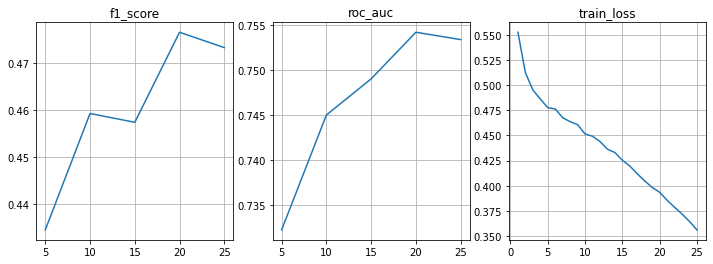

Mean loss=0.388


In [31]:
metrics = {'train_loss': [], 'roc_auc': [], 'f1_score': []}
n_epochs = 25

for epoch in range(1, n_epochs+1):
    avg_loss = 0.0
    for index, batch in enumerate(tqdm(train_emb_dataloader)):
        x_1, x_2, y = batch
        proba = simple_model(x_1, x_2)
        
        loss_t = loss(input=proba, target=y)
        
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        avg_loss += loss_t.item()

    avg_loss /= index
    metrics['train_loss'].append((epoch, avg_loss))

    if epoch % 5 == 0:
        full_proba, full_y = inference_on_embeddings(simple_model, test_emb_dataloader)
        
        metrics['roc_auc'].append((epoch, roc_auc_score(full_y, full_proba)))
        metrics['f1_score'].append((epoch, f1_score(full_y, full_proba > 0.15)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [32]:
full_proba, full_y = inference_on_embeddings(simple_model, test_emb_dataloader)

100%|██████████| 8/8 [00:00<00:00, 31.15it/s]


In [33]:
print(f"Final ROC AUC: {roc_auc_score(full_y, full_proba):.3f}")
print(f"Final F1: {f1_score(full_y, full_proba > 0.15):.2f}")

Final ROC AUC: 0.753
Final F1: 0.47


In [34]:
torch.save(simple_model, "simple_model.torch")

## Полная модель

In [ ]:
train_context_text, test_context_text, train_phrase, test_phrase, train_target, test_target = train_test_split(
    data['context_text'].tolist(),
    data['phrase'].tolist(),
    target,
    test_size=0.25
)

In [ ]:
# Train
train_target_tensors = torch.tensor(train_target, dtype=torch.float32).to(device)

train_tokenized_dataset = TensorDataset(train_context_tokenized, train_phrase_tokenized, train_target_tensors)
train_tokenized_dataloader = DataLoader(train_tokenized_dataset, batch_size=16, shuffle=True)

# Test
test_target_tensors = torch.tensor(test_target, dtype=torch.float32).to(device)

test_tokenized_dataset = TensorDataset(test_context_tokenized, test_phrase_tokenized, test_target_tensors)
test_tokenized_dataloader = DataLoader(test_tokenized_dataset, batch_size=16, shuffle=False)

In [ ]:
class FullModel(torch.nn.Module):
    def __init__(self, language_model, classifier):
        super().__init__()
        self.language_model = language_model
        self.classifier = classifier
        
    def forward(self, tokens_1, tokens_2):
        embeddings_1 = self.language_model(**tokens_1)["last_hidden_state"][:,-1,:]
        embeddings_2 = self.language_model(**tokens_2)["last_hidden_state"][:,-1,:]
        
        return self.classifier(embeddings_1, embeddings_2)

In [ ]:
full_model = FullModel(main_model, simple_model)

In [ ]:
loss = torch.nn.BCELoss()
opt = torch.optim.Adam(simple_model.parameters(), lr=1e-4)

In [ ]:
metrics = {'train_loss': [], 'roc_auc': [], 'f1_score': []}
n_epochs = 100

for epoch in range(n_epochs):
    avg_loss = 0.0
    for index, batch in enumerate(tqdm(train_dataloader)):
        context_tokens, phrase_tokens, y = batch
        proba = full_model(context_tokens, phrase_tokens)
        
        loss_t = loss(input=proba, target=y)
        
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        avg_loss += loss_t.item()

    avg_loss /= index
    metrics['train_loss'].append((epoch, avg_loss))

    if epoch % 5 == 0:
        full_proba = []
        full_y = []
        with torch.no_grad():
            for batch in tqdm(test_dataloader):
                context_tokens, phrase_tokens, y = batch
                full_y.append(y.cpu().detach().numpy())
                full_proba.append(full_model(context_tokens, phrase_tokens).cpu().detach().numpy())
        
        full_proba = np.concatenate(full_proba)
        full_y = np.concatenate(full_y).astype(np.int32)
        metrics['roc_auc'].append((epoch, roc_auc_score(full_y, full_proba)))
        metrics['f1_score'].append((epoch, f1_score(full_y, full_proba > 0.5)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)